In [9]:
from pathlib import Path
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchmetrics
import torchvision
import torchvision.models as pretrained_models
import torchvision.transforms as transforms
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from torchvision import datasets
from tqdm import tqdm


use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
seed = 42
torch.manual_seed(seed)


In [8]:
%reload_ext autoreload
%autoreload 2

In [3]:
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        config,
        path_to_datasets,
        train_transforms,
        val_transforms,
    ):
        super().__init__()
        self.config = config
        self.path_to_datasets = Path(path_to_datasets)
        self.train_transforms = train_transforms
        self.val_transforms = val_transforms

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            datasets.ImageFolder(
                self.path_to_datasets / "train_images", transform=self.train_transforms
            ),
            shuffle=True,
            batch_size=self.config["batch_size"],
            num_workers=16,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            datasets.ImageFolder(
                "bird_dataset/val_images",
                transform=self.val_transforms,
            ),
            batch_size=self.config["batch_size"],
            shuffle=False,
            num_workers=16,
        )

    # def predict_dataloader(self):
    #     return DataLoader(
    #         [image for image, _ in self.validation_dataset],
    #         batch_size=self.config["batch_size"],
    #         shuffle=False,
    #         **kwargs,
    #     )


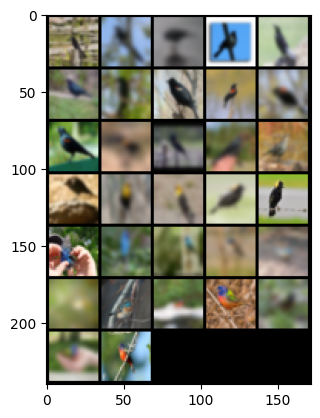

In [4]:
config = {
    "batch_size": 32,
    "width": 32,
    "device": device,
    "learning_rate": 0.001,
    "weight_decay": 0.01,
}

data_transforms = transforms.Compose(
    [
        transforms.Resize((config["width"], config["width"])),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.GaussianBlur(9),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomAutocontrast(p=0.9),
        transforms.RandomPerspective(distortion_scale=0.2, p=0.8),
    ]
)

val_data_transforms = transforms.Compose(data_transforms.transforms[:-3])

dm = DataModule(
    config,
    path_to_datasets="bird_dataset",
    train_transforms=data_transforms,
    val_transforms=val_data_transforms,
)

inputs, labels = next(iter(dm.val_dataloader()))
out = inputs.permute(0, 1, 2, 3)
out = torchvision.utils.make_grid(out, nrow=5)
out = np.transpose(out.detach().numpy(), (1, 2, 0))
plt.imshow(out)
plt.gca().grid(False)


In [6]:
pretrained_models.resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
def dfs_freeze(model):
    for _, child in model.named_children():
        for param in child.parameters():
            param.requires_grad = False
        dfs_freeze(child)


class PreTrainedVGG(pl.LightningModule):
    def __init__(self, config: Dict):
        super().__init__()

        self.config = config
        self.config["model_type"] = type(self)

        self.configure_model()
        self.configure_criterion()

    def configure_model(self):
        self.model = pretrained_models.vgg19_bn(weights="IMAGENET1K_V1")
        self.model.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.LazyLinear(out_features=20),
            # nn.ReLU(),
            # nn.Linear(in_features=128, out_features=20),
        )

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        predictions = y_hat.data.max(1, keepdim=True)[1]

        loss = self.criterion(y_hat, y)
        accuracy = torchmetrics.Accuracy().to(self.config["device"])(
            torch.squeeze(predictions), y
        )
        self.log_dict(
            {"train/loss": loss, "train/accuracy": accuracy},
            on_step=True,
            on_epoch=True,
        )
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        predictions = y_hat.data.max(1, keepdim=True)[1]

        loss = self.criterion(y_hat, y)
        accuracy = torchmetrics.Accuracy().to(self.config["device"])(
            torch.squeeze(predictions), y
        )
        self.log_dict(
            {"val/loss": loss, "val/accuracy": accuracy},
            on_step=True,
            on_epoch=True,
        )
        return loss

    def predict_step(self, batch, batch_idx: int, dataloader_idx: int = None):
        if isinstance(batch, tuple):
            return self(batch[0])
        return self(batch)

    def configure_criterion(self):
        """Configures the criterion / loss"""
        self.criterion = torch.nn.CrossEntropyLoss(reduction="mean")
        self.config["loss_type"] = type(self.criterion)

    def configure_optimizers(self) -> torch.optim:
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.config["learning_rate"],
            weight_decay=self.config["weight_decay"],
        )
        self.config["optimizer_type"] = type(optimizer)
        return optimizer


model = PreTrainedVGG(config)

logger = TensorBoardLogger("tensorboard_logs")
model_checkpoint = ModelCheckpoint(
    dirpath="tmp/",
    filename="epoch={epoch}-loss={val/loss_epoch:.3f}-accuracy={val/accuracy_epoch:.3f}",
    auto_insert_metric_name=False,
    monitor="train/accuracy_epoch",
    mode="max",
    verbose=True,
    save_last=False,
    save_top_k=1,
)
early_stopping = EarlyStopping(
    monitor="val/accuracy_epoch", min_delta=0.00, patience=5, verbose=False, mode="max"
)

trainer = pl.Trainer(
    max_epochs=3,
    callbacks=[model_checkpoint],
    devices="auto",
    accelerator="auto",
    log_every_n_steps=10,
    logger=logger,
)
trainer.fit(
    model,
    datamodule=dm,
)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | VGG              | 20.0 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
20.0 M    Trainable params
0         Non-trainable params
20.0 M    Total params
80.142    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0, global step 10: 'train/accuracy_epoch' reached 0.06250 (best 0.06250), saving model to '/home/matias/RECVIS/recvis22_a3/tmp/epoch=0-loss=5.768-accuracy=0.058.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

Epoch 1, global step 20: 'train/accuracy_epoch' was not in top 1


Validation: 0it [00:00, ?it/s]

Epoch 2, global step 30: 'train/accuracy_epoch' was not in top 1
`Trainer.fit` stopped: `max_epochs=3` reached.


In [21]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
from torch import nn
from torchvision.models import resnet50

In [22]:
model = torch.hub.load("facebookresearch/detr", "detr_resnet50", pretrained=True)
model.eval()
3

Using cache found in /home/matias/.cache/torch/hub/facebookresearch_detr_main
/home/matias/.pyenv/versions/3.9.8/envs/MVA/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/matias/.pyenv/versions/3.9.8/envs/MVA/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


3

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize(800),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


/home/matias/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


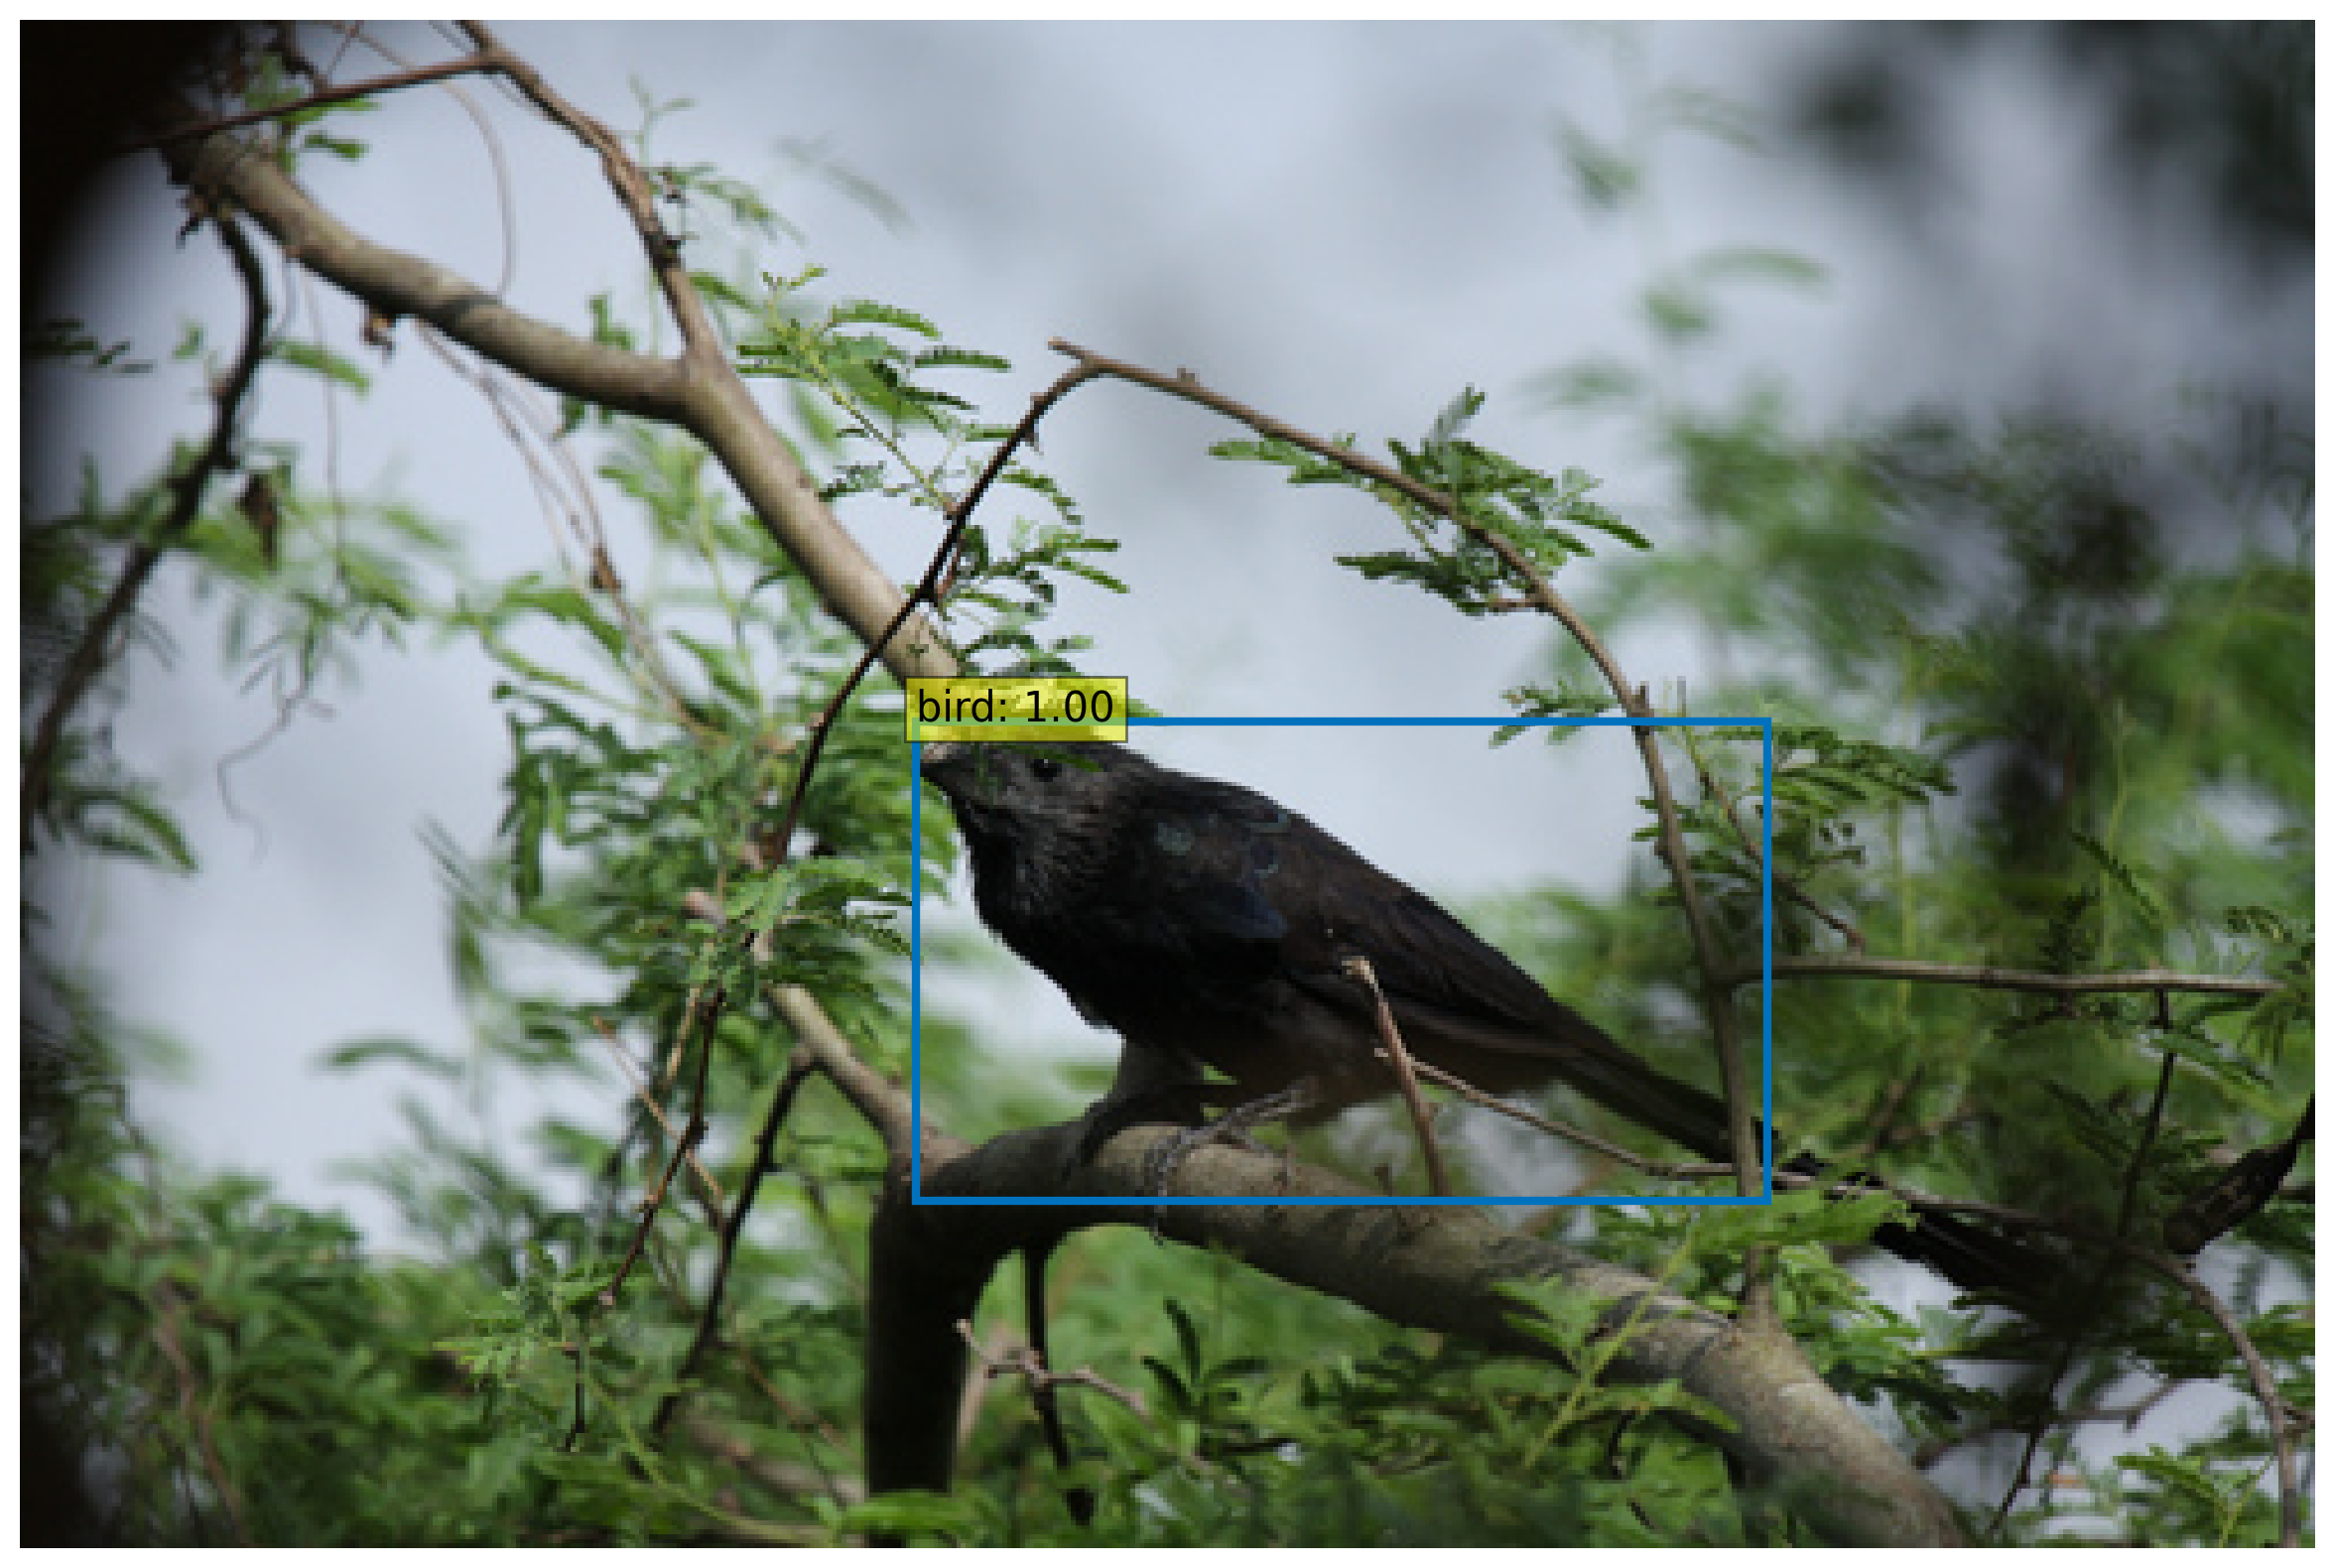

In [20]:
im = Image.open(
    str(
        Path(
            "bird_dataset/train_images/004.Groove_billed_Ani/Groove_Billed_Ani_0006_1763.jpg"
        )
    )
)

# mean-std normalize the input image (batch-size: 1)
img = transform(im).unsqueeze(0)

# propagate through the model
outputs = model(img)

# keep only predictions with 0.7+ confidence
probas = outputs["pred_logits"].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.9

# convert boxes from [0; 1] to image scales
bboxes_scaled = rescale_bboxes(outputs["pred_boxes"][0, keep], im.size)

plot_results(im, probas[keep], bboxes_scaled)


In [7]:
def compute_accuracy_confusion(model, loader):
    y_pred = []
    y_true = []

    for inputs, labels in loader:
        output = model(inputs)
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # Save Prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # Save Truth
    accuracy = accuracy_score(y_true, y_pred)
    cf_matrix = confusion_matrix(y_true, y_pred)
    classes = list(train_loader.dataset.class_to_idx.keys())
    df_cm = pd.DataFrame(
        cf_matrix / np.sum(cf_matrix, axis=1)[:, None],
        index=[i for i in classes],
        columns=[i for i in classes],
    )
    return accuracy, df_cm


# accuracy, cf_dataframe = compute_accuracy_confusion(model, train_loader)
plt.figure(figsize=(12, 7))
sns.heatmap(cf_dataframe, annot=True)

# row : true label
# col : predicted label


NameError: name 'cf_dataframe' is not defined

<Figure size 1200x700 with 0 Axes>

In [ ]:
class PreTrainedRegnet(nn.Module):
    def __init__(self, config: Optional[Dict] = {}):
        super().__init__()

        self.config = config

        self.configure_model()

    def configure_model(self):
        # fully connected linear layers
        self.model = pretrained_models.efficientnet_b0(weights="IMAGENET1K_V1")
        dfs_freeze(self.model)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.LazyLinear(out_features=20),
        )

    def forward(self, x):
        x = self.model(x)
        x = self.classifier(x)
        return x


model = PreTrainedRegnet()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay,
)
learning_rate = 1e-3
weight_decay = 0.01
train(model, train_loader, val_loader, optimizer, 20, save=False)


In [ ]:
model = pretrained_models.efficientnet_v2_l(weights="IMAGENET1K_V1")
model.classifier
